Problem 3: Analysis of SOU similarities

In [1]:
import pickle
import pandas as pd
import numpy as np
import string
import re
import math
import sklearn.metrics.pairwise
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn
import pyspark
import nltk
nltk.download('punkt')
import os

[nltk_data] Downloading package punkt to /Users/weixinyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
f = open('speeches.pkl','rb')
speeches = pickle.load(f)

In [3]:
spch_df = pd.DataFrame(speeches, columns = ['president', 'text', 'year'])

(a) Compute the tf-idf vectors for each SOU address

In [4]:
# Prepare the data
def clean_and_split(s):
    s = s.lower().replace('-', ' ').translate(string.punctuation)
    s = re.sub('(\r\n)+', ' ', s)
    s = re.sub(' +', ' ', s.strip())
    return s.split(' ')

In [5]:
spch_df['text_split'] = spch_df['text'].apply(lambda x: clean_and_split(x))

In [6]:
merged = []
for l in spch_df['text_split']:
    merged += l
merged_unique = np.unique(merged)

In [7]:
# Throw out the 35 most common words and words that appear fewer than 50 times
counts = pd.DataFrame(pd.value_counts(merged))
counts = counts.loc[counts.loc[:,0] > 50,:]
counts = counts.iloc[35:,:]
#vocab = list(counts.index.values)
vocab = counts.index

In [8]:
# Compute the tf-idf vectors
num_doc = spch_df['text_split'].shape[0]
spch_df['nd'] = [pd.DataFrame([d.count(word) for word in vocab], index = vocab) for d in spch_df['text_split']]
num_contain_df = pd.DataFrame([sum([int(df.loc[word]>0) for df in spch_df['nd']]) for word in vocab], index = vocab)

In [9]:
spch_df['tfidf'] = [[float(nd.loc[word]*math.log(num_doc/num_contain_df.loc[word])) for word in vocab] for nd in spch_df['nd']]

(b) Measure Similarity

In [10]:
# Compute the similarity matrix
X = spch_df['tfidf'].copy()
X = list(X)
sim_matrix = sklearn.metrics.pairwise.pairwise_distances(X, metric='cosine')
sim_matrix = 1-sim_matrix

In [11]:
# Get the upper triangle of the similarity matrix
sim_matrix = np.triu(sim_matrix, k=1)

- 50 most similar pairs of SOUs given by different & same Presidents

In [12]:
# Indicator matrix indicating same/different president
ind_matrix = np.array([[int(spch_df['president'][i] != spch_df['president'][j]) for j in range(len(sim_matrix))] for i in range(len(sim_matrix))])

In [13]:
diff_sim_matrix = np.multiply(sim_matrix, ind_matrix)
same_sim_matrix = np.multiply(sim_matrix, 1-ind_matrix)

In [14]:
diff_ind_arr = np.argpartition(diff_sim_matrix, -50, None)[-50:]
same_ind_arr = np.argpartition(same_sim_matrix, -50, None)[-50:]

In [15]:
# Get the indices of the top50 similar SOUs from same/different presidents
same_ind = []
for ind in same_ind_arr:
    same_ind.append((ind//226, ind%226))
diff_ind = []
for ind in diff_ind_arr:
    diff_ind.append((ind//226, ind%226))

In [16]:
same_top50 = []
for ind in same_ind:
    same_top50.append((spch_df.loc[ind[0]]["president"], (spch_df.loc[ind[0]]["year"], spch_df.loc[ind[1]]["year"])))

In [17]:
same_top50

[('William J. Clinton', ('1997', '2000')),
 ('George W. Bush', ('2007', '2005')),
 ('Dwight D. Eisenhower', ('1956', '1954')),
 ('William J. Clinton', ('1994', '1993')),
 ('George W. Bush', ('2007', '2004')),
 ('George W. Bush', ('2006', '2008')),
 ('William Howard Taft', ('1909', '1912')),
 ('Theodore Roosevelt', ('1907', '1906')),
 ('George W. Bush', ('2008', '2005')),
 ('George W. Bush', ('2003', '2007')),
 ('William Howard Taft', ('1911', '1912')),
 ('Andrew Jackson', ('1835', '1834')),
 ('Theodore Roosevelt', ('1905', '1901')),
 ('Benjamin Harrison', ('1892', '1891')),
 ('Grover Cleveland', ('1886', '1885')),
 ('Theodore Roosevelt', ('1905', '1906')),
 ('Theodore Roosevelt', ('1905', '1904')),
 ('James K. Polk', ('1845', '1846')),
 ('Grover Cleveland', ('1894', '1893')),
 ('George W. Bush', ('2006', '2007')),
 ('Barack Obama', ('2010', '2011')),
 ('William McKinley', ('1899', '1898')),
 ('Ulysses S. Grant', ('1874', '1872')),
 ('Barack Obama', ('2009', '2011')),
 ('Chester A. Arth

In [18]:
diff_top50 = []
for ind in diff_ind:
    diff_top50.append(((spch_df.loc[ind[0]]["president"],spch_df.loc[ind[0]]["year"]),(spch_df.loc[ind[1]]["president"], spch_df.loc[ind[1]]["year"])))

In [19]:
diff_top50

[(('Chester A. Arthur', '1884'), ('Grover Cleveland', '1888')),
 (('William Howard Taft', '1910'), ('Grover Cleveland', '1888')),
 (('Chester A. Arthur', '1881'), ('Grover Cleveland', '1888')),
 (('Abraham Lincoln', '1864'), ('Grover Cleveland', '1896')),
 (('Chester A. Arthur', '1883'), ('Grover Cleveland', '1896')),
 (('Abraham Lincoln', '1862'), ('Grover Cleveland', '1896')),
 (('Ulysses S. Grant', '1874'), ('Chester A. Arthur', '1881')),
 (('Grover Cleveland', '1896'), ('Chester A. Arthur', '1884')),
 (('Grover Cleveland', '1896'), ('Chester A. Arthur', '1882')),
 (('Grover Cleveland', '1896'), ('Chester A. Arthur', '1881')),
 (('Grover Cleveland', '1896'), ('Ulysses S. Grant', '1872')),
 (('Ulysses S. Grant', '1874'), ('William Howard Taft', '1910')),
 (('Rutherford B. Hayes', '1880'), ('Grover Cleveland', '1888')),
 (('Abraham Lincoln', '1862'), ('William Howard Taft', '1910')),
 (('Abraham Lincoln', '1862'), ('Rutherford B. Hayes', '1880')),
 (('Abraham Lincoln', '1862'), ('Ulys

- 25 most similar pairs of presidents

In [20]:
# Get the unique list of presidents
president = list(np.unique(list(spch_df['president'])))

# Compute the mean cosine similarity matrix between presidents
sim_matrix_df = pd.DataFrame(sim_matrix+sim_matrix.transpose(),index = spch_df['president'], columns = spch_df['president'])
def get_mean(x):
    if type(x) == float:
        return x
    else:
        return x.mean()
president_sim_matrix = np.array([np.array([get_mean(sim_matrix_df.loc[y, x].mean()) for x in president]) for y in president]) 

In [21]:
# Get the index of the most similar presidents pairs
president_sim_matrix = np.triu(president_sim_matrix,k=1)
pair_ind_arr = np.argpartition(president_sim_matrix, -25, None)[-25:]
pair_ind = []
for ind in pair_ind_arr:
    pair_ind.append((ind//president_sim_matrix.shape[0], ind%president_sim_matrix.shape[0]))

# Return the top25 similar presidents
president_pair = []
for ind in pair_ind:
    president_pair.append((president[ind[0]], president[ind[1]]))
#ind = np.unravel_index(np.argsort(-1*president_sim_matrix, axis=None), president_sim_matrix.shape)
#pre_top25 = [(president[pre_pair_ind[0][i]],\
                  #president[pre_pair_ind[1][i]])for i in range(25)]

In [22]:
president_pair

[('Grover Cleveland', 'Rutherford B. Hayes'),
 ('Rutherford B. Hayes', 'William Howard Taft'),
 ('Franklin Pierce', 'Millard Fillmore'),
 ('Dwight D. Eisenhower', 'Harry S Truman'),
 ('James K. Polk', 'John Tyler'),
 ('Benjamin Harrison', 'William McKinley'),
 ('John Tyler', 'Martin Van Buren'),
 ('Dwight D. Eisenhower', 'John F. Kennedy'),
 ('Franklin Pierce', 'James Buchanan'),
 ('James K. Polk', 'Zachary Taylor'),
 ('James Buchanan', 'Zachary Taylor'),
 ('Franklin Pierce', 'Zachary Taylor'),
 ('Chester A. Arthur', 'William Howard Taft'),
 ('Ronald Reagan', 'William J. Clinton'),
 ('Barack Obama', 'George Bush'),
 ('Andrew Jackson', 'Martin Van Buren'),
 ('Barack Obama', 'Ronald Reagan'),
 ('Barack Obama', 'William J. Clinton'),
 ('Benjamin Harrison', 'Grover Cleveland'),
 ('Abraham Lincoln', 'Chester A. Arthur'),
 ('George Bush', 'William J. Clinton'),
 ('Millard Fillmore', 'Zachary Taylor'),
 ('Chester A. Arthur', 'Rutherford B. Hayes'),
 ('James K. Polk', 'Millard Fillmore'),
 ('G

For the top 50 similar speeches by the same president, most of them occured closely in time and are very similar. Some of the simillar speeches pairs have mentioned the country names, institutes and issues. Yet, there are some that don't seem as similar as the results suggest. 
A better similarity measure could take into account of times that numbers occur, the presence of charts (found in some of the speeches), and the length of the speech. Further algorithm could figure out similar sentence structures, like sentences begin with "I" and use of command versus request.

(c) K-means

In [23]:
# Perform the k-means on tfidf
tfidf = list(spch_df['tfidf'])
c = 10
model = KMeans(n_clusters=c)
sou_kmeans = model.fit(tfidf)

In [24]:
# Get the clusters
sou_cluster = sou_kmeans.predict(tfidf)

In [25]:
spch_df['president'].shape

(226,)

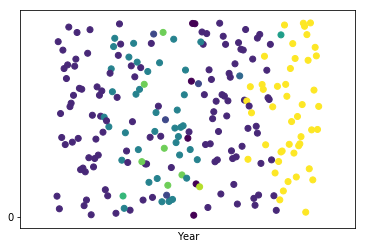

In [26]:
# Visualize the clusters by year
year = list(spch_df['year'])
x = spch_df['year']
y = np.random.rand(sou_cluster.shape[0])
plt.xticks(np.arange(int(min(year)), int(max(year)) + 10, 10))
plt.yticks(np.arange(0,1))
plt.xlabel("Year")
plt.scatter(x, y, c = sou_cluster)

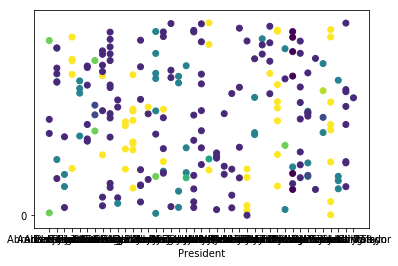

In [27]:
# Visualize the clusters by president
x = spch_df['president']
y = np.random.rand(sou_cluster.shape[0])
plt.yticks(np.arange(0,1))
plt.xlabel("President")
plt.scatter(x, y, c = sou_cluster)

In [28]:
# Function that perform the k-means and visualize by YEAR with different numbers of clusters
def cluster_k_year(k):
    model = KMeans(n_clusters=k)
    kmeans = model.fit(tfidf)
    cluster = kmeans.predict(tfidf)
    x = spch_df['year']
    y = np.random.rand(cluster.shape[0])
    plt.xticks(np.arange(int(min(year)), int(max(year)) + 10, 10))
    plt.yticks(np.arange(0,1))
    plt.xlabel("Year")
    plt.scatter(x, y, c = cluster)
    plt.show()

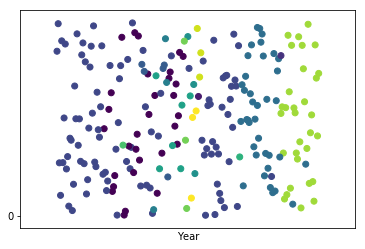

In [35]:
cluster_k_year(15)

The x-axis is year and y-axis is random scattering of points that share the same x-axis. For cluster number between 10-15, the clusters represent a clear division by the year of the speech. The clusters are well separated in the vertical dimension. For cluster number higher or lower, the trend is not that clear. It could mean that the speeches in similar time range are more similar potentially because of the hot issues discussed or words used in a certain time period. 

In [30]:
# Function that perform the k-means and visualize by PRESIDENT with different numbers of clusters
def cluster_k_president(k):
    model = KMeans(n_clusters=k)
    kmeans = model.fit(tfidf)
    cluster = kmeans.predict(tfidf)
    x = spch_df['president']
    y = np.random.rand(cluster.shape[0])
    plt.yticks(np.arange(0,1))
    plt.xlabel("President")
    plt.scatter(x, y, c = cluster)
    plt.show()

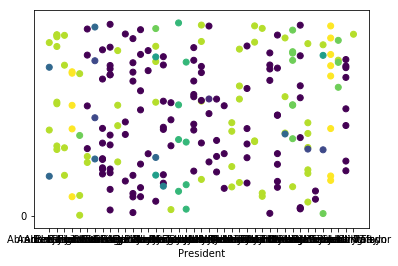

In [36]:
cluster_k_president(10)

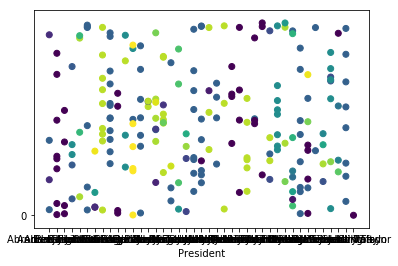

In [32]:
cluster_k_president(40)

The x-axis is president name and the y-axis is random scattering of points that share the same x-axis. For cluster number higher than 10, the trend is pretty clear. The trend is most clear when cluster number is 40. 
The clusters represent a clear division by the president who gives the speech. The clusters are well separated in the vertical dimension. For cluster number lower, the data is not separated well. This could be interpreted as that the speech given by same president share higher similarity.